# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [36]:
## Required imports
import datetime
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots

from pandas.core.nanops import nanmean as pd_nanmean
from statsmodels.tsa.seasonal import _extrapolate_trend
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')

from scipy import stats
from category_encoders import BinaryEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from sklearn.inspection import permutation_importance

In [37]:
# load data
cars = pd.read_csv('data/vehicles.csv')

In [38]:
# set index
cars = cars.set_index('id')

In [39]:
# show columns
cars.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [40]:
# check head
cars.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
id,,,,,,,,,,,,,,,,,
7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


<AxesSubplot:>

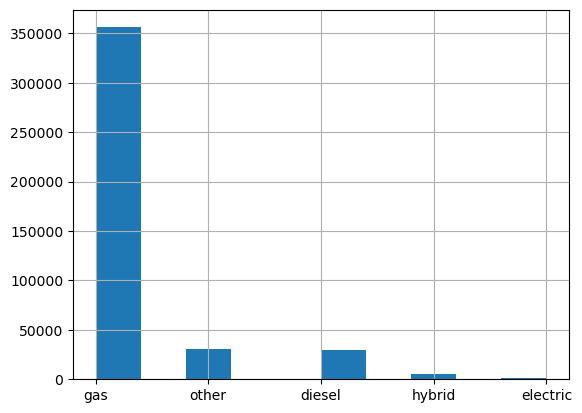

In [41]:
# check histograms
cars['fuel'].hist()


<AxesSubplot:>

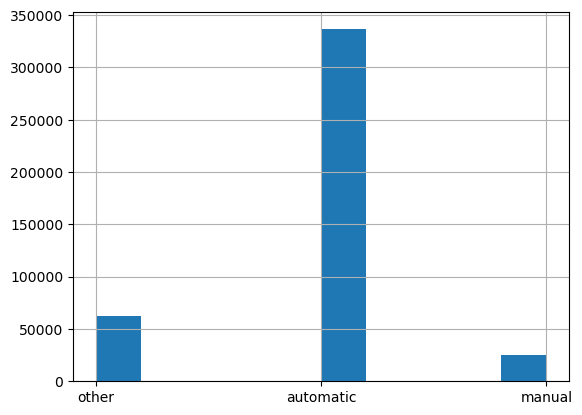

In [42]:
cars['transmission'].hist()

<AxesSubplot:>

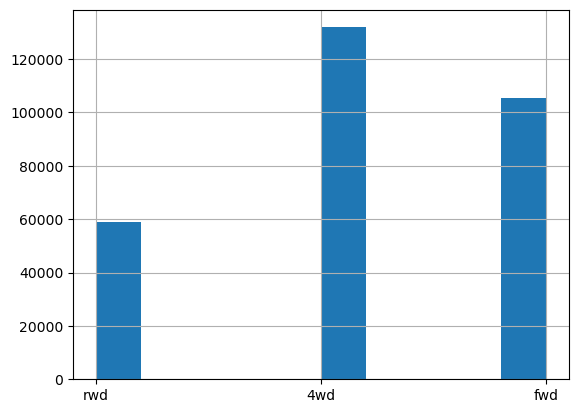

In [43]:
cars['drive'].hist()

<AxesSubplot:>

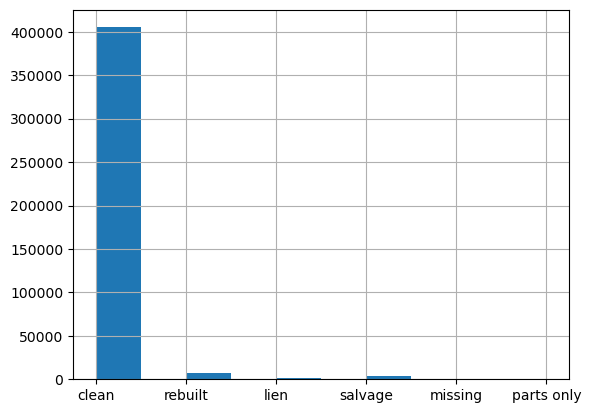

In [44]:
cars['title_status'].hist()

<AxesSubplot:>

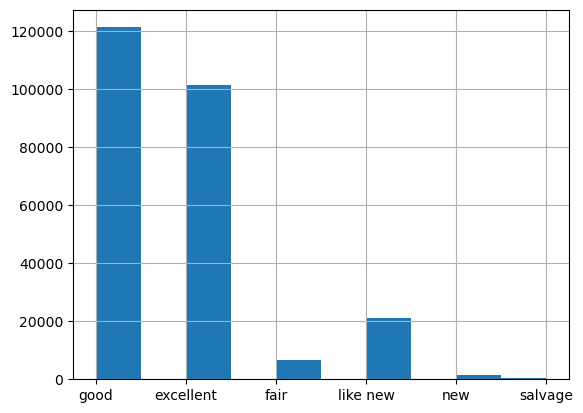

In [45]:
cars['condition'].hist()

<AxesSubplot:>

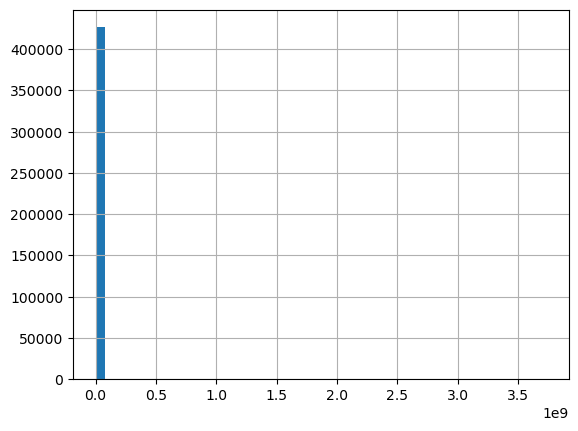

In [46]:
cars['price'].hist(bins=50)

In [47]:
# based on the histograms, we will filter the data set
# remove rows with NaN values
cars = cars.dropna()
# remove duplicate rows with the same VIN
cars = cars.drop_duplicates(subset='VIN')
# remove rows were price = 0
cars = cars[cars['price'] > 0]
# remove rows where fuel = other
cars = cars[cars['fuel'] != 'other']
# drop VIN column
cars = cars.drop('VIN', axis=1)
# drop region column
cars = cars.drop('region', axis=1)
# only keep rows where year > 2012
cars = cars[cars['year'] > 2012]
# only keep rows where price > 1000
cars = cars[cars['price'] > 1000]
# convert cylinders to int by removing the text after the space and if value is other, set to 0
cars['cylinders'] = cars['cylinders'].apply(lambda x: int(x.split()[0]) if x != 'other' else 0)
# convert odometer to int
cars['odometer'] = cars['odometer'].apply(lambda x: int(x))
# convert price to int
cars['price'] = cars['price'].apply(lambda x: int(x))
# keep gas only
cars = cars[cars['fuel'] == 'gas']
# keep automatic only
cars = cars[cars['transmission'] == 'automatic']
# remove cars with 0 cylinders
cars = cars[cars['cylinders'] > 0]
# remove cars with 0 odometer
cars = cars[cars['odometer'] > 0]
# remove parts only in category
cars = cars[cars['title_status'] != 'parts only']
# remove salvage cars
cars = cars[cars['title_status'] != 'salvage']
# condition in good, excellent, like new
cars = cars[(cars['condition'] == 'good') | (cars['condition'] == 'excellent') | (cars['condition'] == 'like new')]

In [48]:
# check value_counts for non numeric columns
non_numeric_columns = cars.select_dtypes(exclude=['int64', 'float64']).columns
for column in non_numeric_columns:
    print(cars[column].value_counts())


ford             1538
chevrolet        1122
nissan            539
toyota            533
honda             388
jeep              350
ram               328
gmc               323
dodge             275
hyundai           264
kia               245
subaru            245
bmw               229
volkswagen        204
mercedes-benz     164
chrysler          137
audi              130
buick             107
mazda             106
cadillac          103
lexus              87
lincoln            67
infiniti           59
volvo              51
acura              51
mitsubishi         42
rover              42
porsche            27
mini               27
fiat               12
jaguar              6
alfa-romeo          3
Name: manufacturer, dtype: int64
f-150                     271
silverado 1500            202
1500                      151
escape                    100
sierra 1500                75
                         ... 
mkc select suv              1
sorento sx awd              1
city express cargo van 

In [49]:
# check correlation
cars.corr()

,price,year,cylinders,odometer
price,1.000000,0.498015,0.516085,-0.389437
year,0.498015,1.000000,-0.032134,-0.557054
cylinders,0.516085,-0.032134,1.000000,0.145713
odometer,-0.389437,-0.557054,0.145713,1.000000


Both cylinders and year have strong possitive correlation
Odometer on the other hand has a negative correlation 

<Figure size 800x640 with 0 Axes>

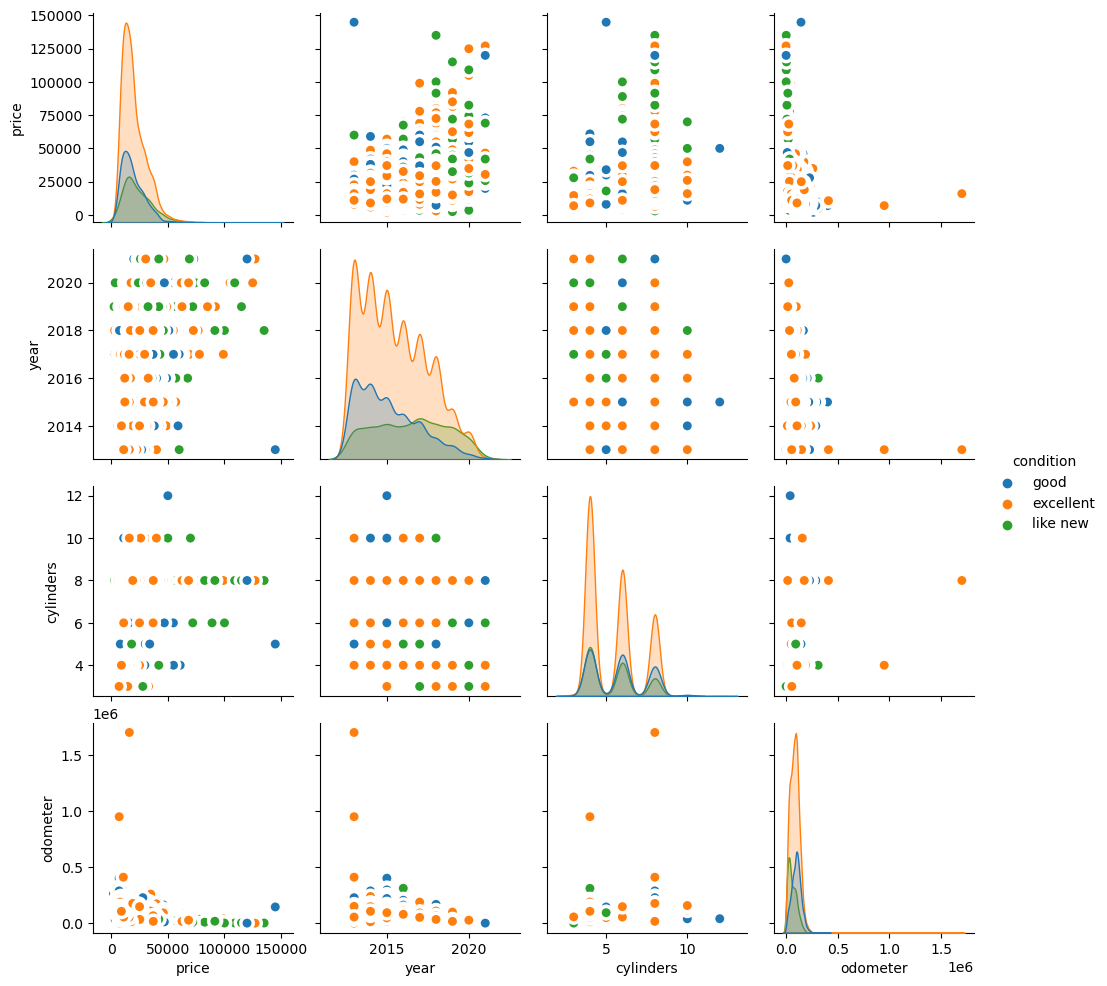

In [50]:
# Pairwise Plot
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(cars, kind="scatter", hue="condition", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.